# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

#### Описание данных

**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**

* Exited — факт ухода клиента

Импортируем необходимые для работы библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Отключим предупрежения SettingWithCopy, добавим для этого строчку:

In [2]:
pd.options.mode.chained_assignment = None

## 1 Подготовка данных

### 1.1 Загрузим данные в переменную data

### Вывод

Данные загружены, теперь можно с нимим ознакомиться

### 1.2 Ознакомимся с данными и информацией о датафрейме

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Визуально с данными всё в порядке, посмотрим информацию о датафрейме.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Вывод

Названия столбцов содержат символы из разных регистров - преобразуем к одному, нижнему.

Также имеются пропуски в столбце tenure - причины пропуска данных неизвестны, закономерность пропусков выявить не удалось.

Вероятнее всего это ошибка при заполнении данных, предположим, что эти данные не заполнялись для клиентов, которые стали таковыми менее года назад.

Возможно, разработчики помогут выяснить причину пропусков и устранить данную проблему.

### 1.3 Заменим названия столбцов (приведём к нижнему регистру) для удобства работы

In [6]:
data.columns = data.columns.str.lower()

### Вывод

Названия столбцов преобразованы к нижнему регистру.

### 1.4 Обработаем пропуски

Заполним пропуски значений в столбце tenure

Сохраним индексы элементов с пропущенными значениями в tenure

In [7]:
indexesna=data.query('tenure.isna()').index

In [8]:
data.loc[indexesna, 'tenure']

30     NaN
48     NaN
51     NaN
53     NaN
60     NaN
        ..
9944   NaN
9956   NaN
9964   NaN
9985   NaN
9999   NaN
Name: tenure, Length: 909, dtype: float64

In [9]:
data.tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [10]:
data.tenure.isna().sum()

909

Заполним пропуски медианным значением, сгруппировав данные по признакам.

Воспользуемся вложенными циклами

In [11]:
for ex in data.exited.unique():
    for act in data.isactivemember.unique():
        for crd in data.hascrcard.unique():
            for gen in data.gender.unique():
                for geo in data.geography.unique():
                    for num in data.numofproducts.unique():
                            data.loc[(data['exited'] == ex) &
                                     (data['isactivemember'] == act) &
                                     (data['hascrcard'] == crd) &
                                     (data['gender'] == gen) &
                                     (data['geography'] == geo) &
                                     (data['numofproducts'] == num) &
                                     (data['tenure'].isna()), 'tenure'] = \
                            data.loc[(data['exited'] == ex) &
                                     (data['isactivemember'] == act) &
                                     (data['hascrcard'] == crd) &
                                     (data['gender'] == gen) &
                                     (data['geography'] == geo) &
                                     (data['numofproducts'] == num), 'tenure'].median()

Проверим, какие значения мы получили

In [12]:
data.loc[indexesna, 'tenure'].value_counts()

5.0    630
6.0    122
4.0     93
5.5     32
3.5      9
3.0      7
8.0      4
7.5      2
4.5      2
2.0      2
7.0      2
2.5      1
9.0      1
6.5      1
1.0      1
Name: tenure, dtype: int64

Мы получили значения с дробной частью, а до заполнения пропусков в данных были только целые значения.

Преобразуем столбуц в цечисленный, тем самым избавимся от дробной части

In [13]:
data.tenure=data.tenure.astype(int)

In [14]:
data.loc[indexesna, 'tenure'].value_counts()

5    662
6    123
4     95
3     16
7      4
8      4
2      3
1      1
9      1
Name: tenure, dtype: int64

In [15]:
data.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

### Вывод

Мы избавились от всех пропусков.

### 1.5 Проверим датафрейм на дубликаты

In [16]:
data.duplicated().sum()

0

### Вывод

Явных дубликатов не найдено

### 1.6 Избавимся от лишних данных в датафрейме, которые не будут участвовать в нашем анализе

In [17]:
data.surname.value_counts()

Smith        32
Scott        29
Martin       29
Walker       28
Brown        26
             ..
Tillman       1
Rodriguez     1
Mach          1
Randolph      1
Yegorov       1
Name: surname, Length: 2932, dtype: int64

Удалим столбцы rownumber, customerid - они нужны для отображения порядка хранения данных.

surname - не является значением для измерения чего-либо и содержит много уникальных значений - его тоже удалим.

In [18]:
data.drop(columns=['rownumber', 'customerid', 'surname'], axis=1, inplace=True)

### Вывод

Мы избавились от лишних данных в нашем датафрейме и теперь можем приступать к кодированию признаков.

### 1.7 Произведём разбивку датафрейма на выборки

Разобъём полученный датафрейм на три выборки:
- обучающую
- валидационную
- тестовую

Разбивку проведём в два этапа, сначала от всего датафрейма отделим 60% данных для обучения, а остальные 40% разделим ещё пополам на две выборки.

В каждой выборке выделим целевой признак - target

In [19]:
df, df_test = train_test_split(data, test_size=0.4, random_state=20, stratify=data.exited)

In [20]:
features_train = df.drop(['exited'], axis=1)
target_train = df['exited']

In [21]:
features = df_test.drop(['exited'], axis=1)
target = df_test['exited']

features_test, features_valid, target_test, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=20, stratify=target)

In [22]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


### Вывод

Мы разделили данные на три выборки в пропорциях 60/20/20 и в каждой выборке выделили целевой признак

### 1.8 Произведём прямое кодирование методом OneHotEncoding столбцов geography и gender

Т.к. метод Ordinal Encoding не подходит для логистической регрессии, а метод OneHotEncoding подходит для всех трёх, рассматриваемых нами, моделей, то будем использовать только его.

Преобразуем категориальные признаки в численные, а чтобы избежать дамми-ловушки воспользуемся опцией drop_first=True

Преобразованный датафрейм сохраним в переменной data_ohe

In [23]:
# data_ohe = pd.get_dummies(data, drop_first=True)

Проверим наше преобразование

In [24]:
# data_ohe.head()

### Вывод

Кодирование категориальных признаков выполнено с учётом дамми-ловушки, т.е. у нас не будет излишних признаков.

#### OneHotEncoder

In [25]:
enc = OneHotEncoder(handle_unknown='ignore')

In [26]:
enc_columns = ['geography', 'gender']
enc.fit(features_train[enc_columns])

OneHotEncoder(handle_unknown='ignore')

In [27]:
features_train[enc.get_feature_names(enc_columns)] = enc.transform(features_train[enc_columns]).toarray()

C:\Users\roum-\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
features_train.drop(enc_columns, axis=1, inplace=True)

In [29]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
8152,654,36,2,0.00,2,1,1,146652.11,0.0,0.0,1.0,1.0,0.0
6044,684,46,0,0.00,2,1,1,36376.97,1.0,0.0,0.0,0.0,1.0
5422,607,31,1,102523.88,1,1,1,166792.71,1.0,0.0,0.0,1.0,0.0
2275,550,48,6,0.00,2,1,1,191870.28,1.0,0.0,0.0,1.0,0.0
9933,797,46,8,0.00,1,0,0,162668.33,1.0,0.0,0.0,1.0,0.0


Закодируем валидационную выборку

In [30]:
features_valid[enc.get_feature_names(enc_columns)] = enc.transform(features_valid[enc_columns]).toarray()
features_valid.drop(enc_columns, axis=1, inplace=True)
features_valid.head()

C:\Users\roum-\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
8627,639,42,4,0.00,2,0,0,167682.37,1.0,0.0,0.0,1.0,0.0
822,642,34,8,0.00,1,1,0,72085.10,0.0,0.0,1.0,0.0,1.0
9293,771,38,5,137657.71,2,1,0,72985.61,0.0,1.0,0.0,1.0,0.0
2138,718,45,5,105266.32,2,1,1,193724.51,0.0,0.0,1.0,0.0,1.0
8862,813,59,2,135078.41,1,1,0,187636.06,0.0,1.0,0.0,0.0,1.0


Закодируем тестовую выборку

In [31]:
features_test[enc.get_feature_names(enc_columns)] = enc.transform(features_test[enc_columns]).toarray()
features_test.drop(enc_columns, axis=1, inplace=True)
features_test.head()

C:\Users\roum-\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
2288,619,30,7,70729.17,1,1,1,160948.87,1.0,0.0,0.0,1.0,0.0
1407,721,69,2,108424.19,1,1,1,178418.35,1.0,0.0,0.0,0.0,1.0
1477,776,37,2,0.00,1,0,1,8065.00,1.0,0.0,0.0,0.0,1.0
7919,593,31,8,112713.34,1,1,1,176868.89,0.0,0.0,1.0,0.0,1.0
7764,685,44,2,119657.53,1,1,0,145387.05,0.0,1.0,0.0,1.0,0.0


In [32]:
first_columns = ['geography_Spain', 'gender_Female']
features_train.drop(first_columns, axis=1, inplace=True)
features_valid.drop(first_columns, axis=1, inplace=True)
features_test.drop(first_columns, axis=1, inplace=True)

### Вывод

Кодирование категориальных признаков выполнено.

### 1.9 Займёмся масштабированием признаков

Выделим численные признаки для преобразования\стандартизации и произведём пробразование наших выборок

In [33]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Оценим преобразование

In [34]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,gender_Male
8152,0.021532,-0.264312,-1.084670,-1.220821,0.835150,1,1,0.806612,0.0,0.0,0.0
6044,0.333066,0.690688,-1.808870,-1.220821,0.835150,1,1,-1.115432,1.0,0.0,1.0
5422,-0.466538,-0.741812,-1.446770,0.422953,-0.891556,1,1,1.157653,1.0,0.0,0.0
2275,-1.058453,0.881688,0.363729,-1.220821,0.835150,1,1,1.594744,1.0,0.0,0.0
9933,1.506511,0.690688,1.087929,-1.220821,-0.891556,0,0,1.085767,1.0,0.0,0.0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,gender_Male
8627,-0.134235,0.308688,-0.360470,-1.220821,0.835150,0,0,1.173160,1.0,0.0,0.0
822,-0.103081,-0.455312,1.087929,-1.220821,-0.891556,1,0,-0.493056,0.0,0.0,1.0
9293,1.236515,-0.073312,0.001629,0.986256,0.835150,1,0,-0.477360,0.0,1.0,0.0
2138,0.686138,0.595188,0.001629,0.466922,0.835150,1,1,1.627062,0.0,0.0,1.0
8862,1.672663,1.932189,-1.084670,0.944902,-0.891556,1,0,1.520943,0.0,1.0,1.0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,gender_Male
2288,-0.341924,-0.837313,0.725829,-0.086814,-0.891556,1,1,1.055798,1.0,0.0,0.0
1407,0.717292,2.887189,-1.084670,0.517553,-0.891556,1,1,1.360283,1.0,0.0,1.0
1477,1.288437,-0.168812,-1.084670,-1.220821,-0.891556,0,1,-1.608896,1.0,0.0,1.0
7919,-0.611920,-0.741812,1.087929,0.586321,-0.891556,1,1,1.333277,0.0,0.0,1.0
7764,0.343451,0.499688,-1.084670,0.697658,-0.891556,1,0,0.784563,0.0,1.0,0.0


### Вывод

Мы выполнили преобразование численных признаков и данные подготовлены для использования в модели.

## Вывод

Данные загружены.

Названия столбцов преобразованы к нижнему регистру.

Пропуски в столбце tenure - заполнены медианными значениями.

Явных дубликатов не найдено.

Мы избавились от лишних данных в нашем датафрейме, удалили столбцы rownumber, customerid и surname.

Выполнили кодирование категориальных признаков с учётом дамми-ловушки.

Выделили численные признаки и выполнили их масштабирование.

В итоге мы получили три выборки в пропорциях 60/20/20, а также из каждой выборки выделили целевой признак

## 2 Исследование задачи

Наша задача относится к классификации (уйдёт клиент или нет), поэтому рассмотрим три модели классификации и выберем лучшую.

Для оценки адекватности сравним наши модели с константной моделью.

При оценке эффективности модели будем считать приоритетной метрику - F1-мера.

### 2.1 Оценим баланс классов целевого признака

Для подсчёта классов в целевом признаке применим метод value_counts() и получим частоты\долю каждого класса

0    0.7963
1    0.2037
Name: exited, dtype: float64


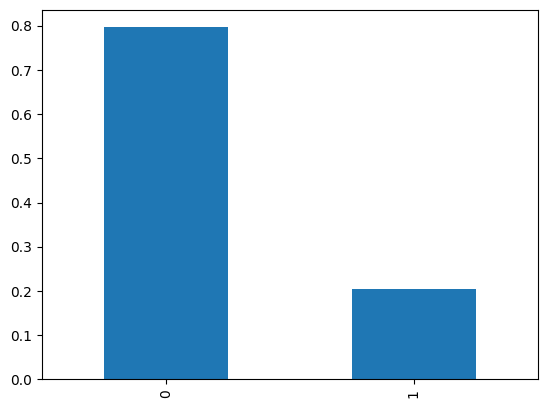

In [35]:
class_frequency=data.exited.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Как видим, около 80% клиентов банка по настоящее время являются его клиентами и 20% уже ушли.

### Вывод

Классы целевого признака не сбалансированы.

### 2.2 Константная модель для проверки адекватности

Создадим константную модель: любому объекту она прогнозирует класс «0». Сохраним её предсказания в переменной target_pred_constant. 

In [36]:
target_pred_constant = pd.Series([0]*len(data.exited))
print(f'Accuracy константной модели: {accuracy_score(data.exited, target_pred_constant):.5f}')

Accuracy константной модели: 0.79630


### Вывод

Метрика константной модели соответсвует частоте прогнозируемого класса.

### 2.2 Решающее дерево

In [37]:
best_model = None
best_accuracy = 0
best_depth=0
best_f1=0
best_auc_roc=0
# Переберём модели с разной глубиной деревьев и найдём наилучшую из них
# Ограничим глубину значеннием 10
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=20, max_depth=depth) # Зададим гиперпараметры нашей модели
    model.fit(features_train, target_train) # Обучим модель
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    accuracy = accuracy_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid,predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > best_f1:
        best_model = model # сохраним наилучшую модель
        best_accuracy = accuracy # сохраним наилучшее значение accuracy на валидационных данных
        best_depth = depth # сохраним гиперпараметр модели максимальную глубину
        best_f1 = f1 # сохраним наилучшее значение f1-меры на валидационных данных
        best_auc_roc=auc_roc
print(f"F1 наилучшей модели на валидационной выборке: {best_f1:.5f}\nAUC-ROC: {best_auc_roc:.5f}\nAccuracy: {best_accuracy:.5f}\nМаксимальная глубина: {best_depth}")

F1 наилучшей модели на валидационной выборке: 0.57895
AUC-ROC: 0.82887
Accuracy: 0.85600
Максимальная глубина: 7


In [38]:
model = DecisionTreeClassifier(random_state=20, max_depth=7)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [39]:
print(confusion_matrix(target_valid, predicted_valid))

[[1514   78]
 [ 210  198]]


#### Оценим метрики модели

In [40]:
print(f'F1: {f1_score(target_valid,predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.57895
AUC_ROC: 0.82887
Accuracy: 0.85600
Precision: 0.71739
Recall: 0.48529


### Вывод

Получили неплохие результаты, но до желаемого значения метрики F1=0.59 мы не добрались.

### 2.3 Случайный лес

Найдём гиперпараметры для нашего леса

In [41]:
best_depth = 0
best_est = 0
best_accuracy = 0
best_model = None
best_f1=0
best_auc_roc=0
for est in range(26, 29): # Диапазоны изменены для сокращения времени расчётов, изначально они шире
    for depth in range(21, 24):
        model = RandomForestClassifier(random_state=20, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        accuracy = model.score(features_valid, target_valid)
        f1 = f1_score(target_valid, predicted_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1:
            best_model = model
            best_accuracy = accuracy
            best_est = est
            best_depth = depth
            best_f1 = f1
            best_auc_roc = auc_roc

print(f"F1 наилучшей модели на валидационной выборке: {best_f1:.5f}\nAUC-ROC: {best_auc_roc:.5f}")
print(f"Accuracy: {best_accuracy:.5f}\nКоличество деревьев: {best_est}\nМаксимальная глубина: {best_depth}")

F1 наилучшей модели на валидационной выборке: 0.60870
AUC-ROC: 0.83188
Accuracy: 0.86950
Количество деревьев: 27
Максимальная глубина: 22


In [42]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22) # обучим модель с заданным количеством деревьев
model.fit(features_train, target_train) # обучим модель на тренировочной выборке
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [43]:
print(confusion_matrix(target_valid, predicted_valid))

[[1536   56]
 [ 205  203]]


#### Оценим метрики модели

In [44]:
print(f'F1: {f1_score(target_valid,predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.60870
AUC_ROC: 0.83188
Accuracy: 0.86950
Precision: 0.78378
Recall: 0.49755


### Вывод

Получили результаты лучше чем у решающего дерева, даже удалось достичь значения F1: 0.60423

### 2.4 Логистическая регрессия

In [45]:
model = LogisticRegression(random_state=20, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [46]:
print(confusion_matrix(target_valid, predicted_valid))

[[1528   64]
 [ 308  100]]


#### Оценим метрики модели

In [47]:
print(f'F1: {f1_score(target_valid,predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.34965
AUC_ROC: 0.75314
Accuracy: 0.81400
Precision: 0.60976
Recall: 0.24510


### Вывод

Получили результаты хуже чем у других моделей.

### 2.5 Проверка адекватности

Все рассмотренные нами модели смогли превзойти константную модель и поэтому их можно считать адекватными.

## Вывод

Из тёх рассматриваемых моделей наиболее высокие характеристики показала модель случайного леса.

Мы добились следующих показателей метрик:

* F1: **0.60805**
* AUC_ROC: **0.84154**

Безусловно, её и будем рассматривать в дальнейшем и постараемся ещё улучшить её характеристики подборкой дополнительных гиперпараметров, изменением порога и с помощью балансировки классов.

## 3 Борьба с дисбалансом

### 3.1 Взвешивание классов

Придадим объектам редкого класса больший вес, используя параметр модели class_weight='balanced'

In [48]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [49]:
print(confusion_matrix(target_valid, predicted_valid))

[[1529   63]
 [ 212  196]]


#### Оценим метрики модели

In [50]:
print(f'F1: {f1_score(target_valid,predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.58771
AUC_ROC: 0.83977
Accuracy: 0.86250
Precision: 0.75676
Recall: 0.48039


### Вывод

К сожалению, использование взвешивания классов не дало нам увеличения метрик.

Мы наблюдаем снижение значения метрики F1 и с ней же снижается метрика AUC-ROC.

### 3.2 Увеличение выборки

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=20)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Проверим теперь баланс классов

1    0.50569
0    0.49431
Name: exited, dtype: float64


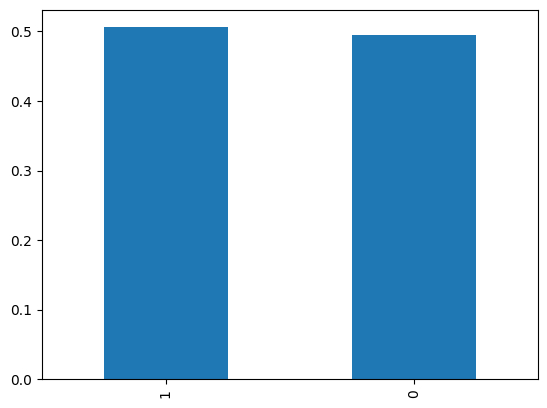

In [52]:
class_frequency=target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Теперь распределение целевого признака по классам более равномерное, поэтому будем считать, что классы сбалансированы.

In [53]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [54]:
print(confusion_matrix(target_valid, predicted_valid))

[[1475  117]
 [ 184  224]]


#### Оценим метрики модели

In [55]:
print(f'F1: {f1_score(target_valid, predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.59813
AUC_ROC: 0.84282
Accuracy: 0.84950
Precision: 0.65689
Recall: 0.54902


### Вывод

Увеличением выборки позволило нам добиться высокой метрики F1, также увеличился показатель AUC-ROC, но он оказался несколько ниже в сравнении с несбалансированными классами.

### 3.3 Уменьшение выборки

In [56]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=20)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=20)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=20)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

1    0.505795
0    0.494205
Name: exited, dtype: float64


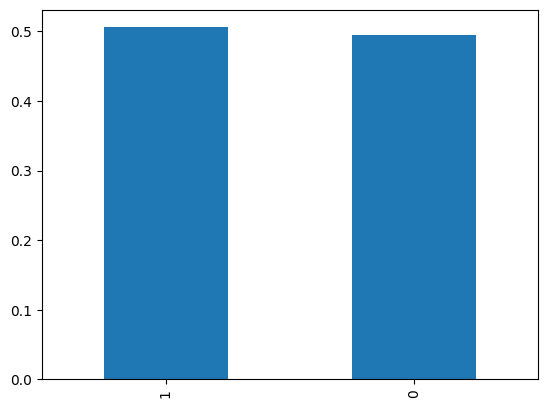

In [57]:
class_frequency=target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Теперь распределение целевого признака по классам более равномерное, поэтому будем считать, что классы сбалансированы.

In [58]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#### Построим матрицу ошибок

In [59]:
print(confusion_matrix(target_valid, predicted_valid))

[[1248  344]
 [  99  309]]


#### Оценим метрики модели

In [60]:
print(f'F1: {f1_score(target_valid, predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.58247
AUC_ROC: 0.84667
Accuracy: 0.77850
Precision: 0.47320
Recall: 0.75735


### Вывод

Уменьшением выборки мы повысили показатель AUC-ROC, но при этом F1 мы получили ниже в сравнении с несбалансированными классами.

### 3.4 Изменение порога (threshold)

Изменением порогового значения мы можем откалибровать оценку вероятности принадлежности предсказания к какому-то классу.

In [61]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold=0
best_accuracy = 0
best_model = None
best_f1=0
best_auc_roc=0
for threshold in np.arange(0, 0.51, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    accuracy = model.score(features_valid, target_valid)
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > best_f1:
        best_model = model
        best_accuracy = accuracy
        best_f1 = f1
        best_auc_roc = auc_roc
        best_threshold = threshold
print(f"F1 наилучшей модели на валидационной выборке: {best_f1:.5f}\nAUC-ROC: {best_auc_roc:.5f}")
print(f"Порог: {best_threshold:.2f}")

F1 наилучшей модели на валидационной выборке: 0.63079
AUC-ROC: 0.83188
Порог: 0.34


In [62]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.34

#### Построим матрицу ошибок

In [63]:
print(confusion_matrix(target_valid, predicted_valid))

[[1453  139]
 [ 156  252]]


#### Оценим метрики модели

In [64]:
print(f'F1: {f1_score(target_valid, predicted_valid):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')
print(f'Accuracy: {accuracy_score(target_valid, predicted_valid):.5f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.5f}')
print(f'Recall: {recall_score(target_valid, predicted_valid):.5f}')

F1: 0.63079
AUC_ROC: 0.83188
Accuracy: 0.85250
Precision: 0.64450
Recall: 0.61765


Изменяя порог (калибруя оценку модели), мы добились максимального показателя метрики F1, на которую мы и ориентируемся в нашем исследовании, а также добились максимального показателя AUC-ROC в сбалансированных выборках, который оказался равен этому же показателю с несбалансированными классами.

#### PR-кривая

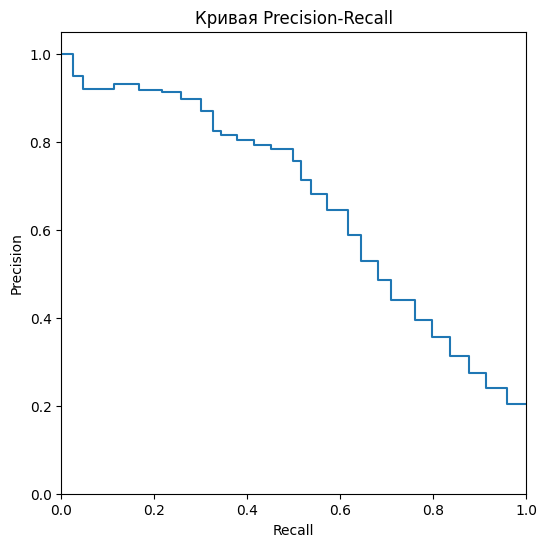

In [65]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Вид PR-кривой гворит о высоком качестве модели

#### ROC-кривая

In [66]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

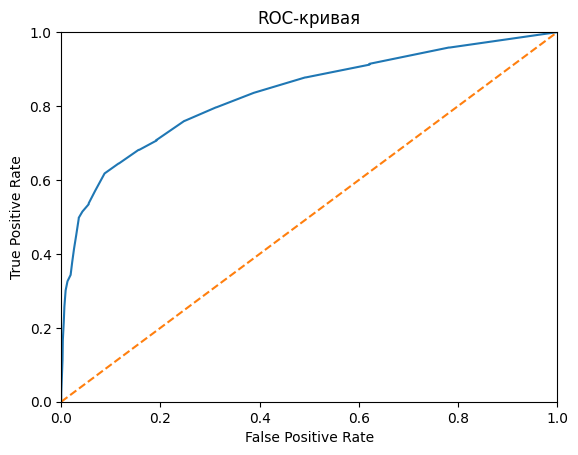

In [67]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

ROC-кривая нашей модели также выше ROC-кривой случайной модели, что также говорит о её высоком качестве.

#### AUC-ROC

In [68]:
print(f'AUC_ROC: {roc_auc_score(target_valid, probabilities_one_valid):.5f}')

AUC_ROC: 0.83188


Площадь под ROC-кривой больше 0.5, а это значит, что наша модель способна определять большее количество истинно положительных значений и истинно отрицательных, нежели чем ложно положительных и ложно отрицательных.

### Вывод

Изменением порога классификации мы добились максимально высокого показателя интересующей нас метрики. 

А характеристики модели говорят о том, что она способна выдавать больше верных предсказаний, нежели ошибочных.

## Вывод

Наибольший прирост в значениях метрик даёт увеличение выборки и изменение порога классификации.

Мы добились желаемого результата и получили высокие показатели метрик модели.

Осталось проверить работу модели на тестовой выборке.

## 4 Тестирование модели

Проведём тестирование нашей модели.

Но сначала объединим в одну train и valid выборки и обучим модель на ней.

In [69]:
df_features = pd.concat([features_train, features_valid])
df_target = pd.concat([target_train, target_valid])

In [70]:
model = RandomForestClassifier(random_state=20, n_estimators=27, max_depth=22)
model.fit(df_features, df_target)
# predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.34

#### Построим матрицу ошибок

In [71]:
print(confusion_matrix(target_test, predicted_test))

[[1444  149]
 [ 160  247]]


#### Оценим метрики модели

In [72]:
print(f'F1: {f1_score(target_test, predicted_test):.5f}')
print(f'AUC_ROC: {roc_auc_score(target_test, probabilities_one_test):.5f}')
print(f'Accuracy: {accuracy_score(target_test, predicted_test):.5f}')
print(f'Precision: {precision_score(target_test, predicted_test):.5f}')
print(f'Recall: {recall_score(target_test, predicted_test):.5f}')

F1: 0.61519
AUC_ROC: 0.84997
Accuracy: 0.84550
Precision: 0.62374
Recall: 0.60688


Отличный резльтат на тестовой выборке, нам удалось добиться от модели результата метрики F1 более 0.59

#### Оценим важность признаков для нашей модели

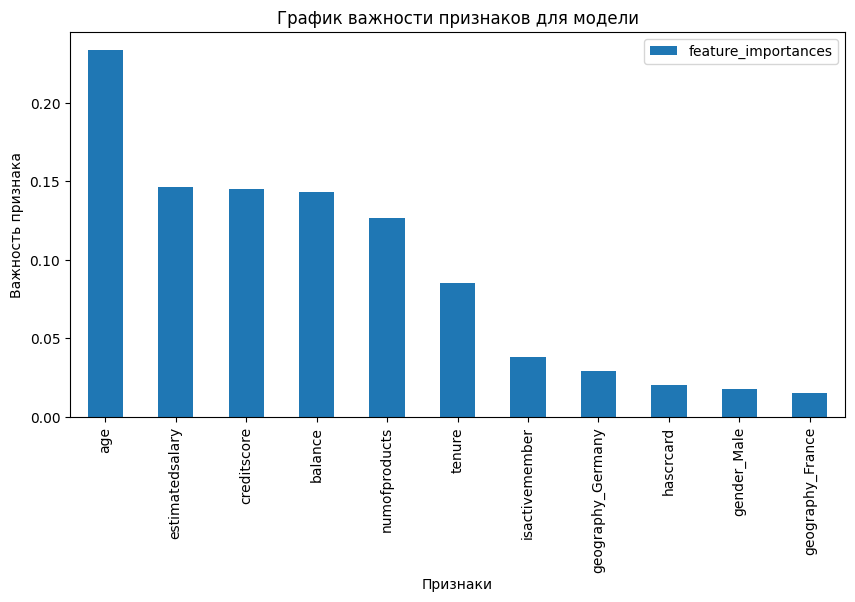

In [73]:
features_for_plt=pd.DataFrame({'feature_names': df_features.columns, 'feature_importances': model.feature_importances_}).sort_values(by='feature_importances', ascending=False)
features_for_plt.plot(x='feature_names', y='feature_importances', kind='bar', figsize=(10,5))
plt.title('График важности признаков для модели')
plt.xlabel('Признаки')
plt.ylabel('Важность признака')
plt.show()

Наиболее важными признаками выступают age, numofproducts, balance, estimatedsalary и creditscore

## Вывод

Модель на тестовой выборке подтвердила свою способность отличать положительные значения класса от отрицательных и с большой степенью вероятности выполняет это верно.

## Вывод

Данные загружены.

Названия столбцов преобразованы к нижнему регистру.

Пропуски в столбце tenure - заполнены медианным значением.

Явных дубликатов не найдено.

Мы избавились от лишних данных в нашем датафрейме, удалили столбцы rownumber, customerid и surname.

Выполнили кодирование категориальных признаков с учётом дамми-ловушки.

Выделили численные признаки и выполнили их масштабирование.

В итоге мы получили три выборки в пропорциях 60/20/20, а также из каждой выборки выделили целевой признак

Из тёх рассматриваемых моделей наиболее высокие характеристики показала модель случайного леса.

Рассмотрели разные варианты балансировки классов и выяснили, что наибольший прирост в значениях метрик даёт увеличение выборки и изменение порога классификации.

Мы добились желаемого результата и получили высокие показатели метрик модели.

Отличный резльтат, на тестовой выборке нам удалось добиться от модели значений метрик F1: 0.62228
AUC_ROC: 0.84857

Модель на тестовой выборке подтвердила свою способность отличать положительные значения класса от отрицательных и с большой степенью вероятности выполняет это верно.